In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import collections
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import pearsonr
import matplotlib.patches as ptch

# 1. Pre-proccessing

In [2]:
data = pd.read_csv("neo_v2.csv")
data.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [3]:
data.shape

(90836, 10)

## 1.2 Removing some features

- **remove "id" column**
- **remove "name" column to avoid possible correlation between the name and label by the classifiers** 
- **remove "orbiting_body" and "sentry_object" since they are the samle for all rows**

In [4]:
data.drop(["id", "name", "orbiting_body", "sentry_object"], axis=1, inplace=True)
data.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True


## 1.3 Handle missing values

In [5]:
sip = SimpleImputer(missing_values=np.nan, strategy="mean")
data.iloc[:, :-1] = sip.fit_transform(data.iloc[:, :-1].values)

## 1.4 Detect outliers with z-score

In [6]:
rows_to_drop = []
for col in data.iloc[:, :-1].columns:
    z_scores = stats.zscore(data[col])
    for i in range(len(z_scores)):
        if abs(z_scores[i]) > 3:
            rows_to_drop.append(i)

rows_to_drop = list(set(rows_to_drop))
data = data.drop(rows_to_drop)
data.reset_index(drop=True, inplace=True)

In [7]:
data.shape

(89021, 6)

## 1.5 set features and label

In [8]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [9]:
X.shape

(89021, 5)

## 1.6 Label Encoding

In [10]:
lb_encoder = LabelEncoder()
y = lb_encoder.fit_transform(y)

## 1.7 Split data sets and Base Accuracy

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
base_line_for_accuracy = 0
counters = collections.Counter(y_test)
labels = list(set(y_test))
if counters[labels[0]] > counters[labels[1]]:
    base_line_for_accuracy = counters[labels[0]] / len(y_test)
else:
    base_line_for_accuracy = counters[labels[1]] / len(y_test)
base_line_for_accuracy = round(base_line_for_accuracy, 3)
print("Base Accuracy: {}".format(str(base_line_for_accuracy)))

Base Accuracy: 0.907


## 1.8 Feature Scaling

In [12]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 2. Logistic Regression Classifying

In [13]:
def run_Logistic_Reg_Classifier(X_train, X_test, y_train, y_test, base_acc):
    lr_classif = LogisticRegression(random_state=0)
    lr_classif.fit(X_train, y_train)
    y_pred_lr_classif = lr_classif.predict(X_test)
    cm_lr_classif = confusion_matrix(y_test, y_pred_lr_classif)
    print("Confusion Matrix")
    print(cm_lr_classif)
    acc_lr_classif = accuracy_score(y_test, y_pred_lr_classif)
    acc_lr_classif = round(acc_lr_classif, 3)
    print()
    print("Accuracy for Logistic Regression Classifier: {}".format(str(acc_lr_classif)))
    print("Base Line Accuracy is: {}".format(str(base_acc)))
    return lr_classif.predict_proba(X_test)

In [14]:
y_prob_logistic_reg = run_Logistic_Reg_Classifier(X_train, X_test, y_train, y_test, base_line_for_accuracy)

Confusion Matrix
[[15998   149]
 [ 1523   135]]

Accuracy for Logistic Regression Classifier: 0.906
Base Line Accuracy is: 0.907


# 3. K-Nearest Neighbors

In [15]:
def run_KNN_Classifier(X_train, X_test, y_train, y_test, base_acc):
    knn_classif = KNeighborsClassifier(n_neighbors=70, metric="minkowski", p=2)
    knn_classif.fit(X_train, y_train)
    y_pred_knn_classif = knn_classif.predict(X_test)
    cm_knn_classif = confusion_matrix(y_test, y_pred_knn_classif)
    print("Confusion Matrix")
    print(cm_knn_classif)
    acc_knn_classif = accuracy_score(y_test, y_pred_knn_classif)
    acc_knn_classif = round(acc_knn_classif, 3)
    print()
    print("Accuracy for KNN Classifier: {}".format(str(acc_knn_classif)))
    print("Base Line Accuracy is: {}".format(str(base_acc)))
    return  knn_classif.predict_proba(X_test)

In [16]:
y_prob_knn = run_KNN_Classifier(X_train, X_test, y_train, y_test, base_line_for_accuracy)

Confusion Matrix
[[16046   101]
 [ 1429   229]]

Accuracy for KNN Classifier: 0.914
Base Line Accuracy is: 0.907


# 4. SVC

In [17]:
def run_svc_Classifier(X_train, X_test, y_train, y_test, kernel, base_acc):
    svc_classif = SVC(kernel=kernel, random_state=0, probability=True)
    svc_classif.fit(X_train, y_train)
    y_pred_svc_classif = svc_classif.predict(X_test)
    cm_svc_classif = confusion_matrix(y_test, y_pred_svc_classif)
    print("Confusion Matrix")
    print(cm_svc_classif)
    acc_svc_classif = accuracy_score(y_test, y_pred_svc_classif)
    acc_svc_classif = round(acc_svc_classif, 3)
    print()
    print("Accuracy for Support Vector Classifier with " + kernel +  " kernel: {}".format(str(acc_svc_classif)))
    print("Base Line Accuracy is: {}".format(str(base_acc)))
    return svc_classif.predict_proba(X_test)

In [18]:
y_prob_linear_svc = run_svc_Classifier(X_train, X_test, y_train, y_test, 'linear', base_line_for_accuracy)

Confusion Matrix
[[16147     0]
 [ 1658     0]]

Accuracy for Support Vector Classifier with linear kernel: 0.907
Base Line Accuracy is: 0.907


# 5. Kernel SVC

In [19]:
y_prob_kernel_svc = run_svc_Classifier(X_train, X_test, y_train, y_test, 'rbf', base_line_for_accuracy)

Confusion Matrix
[[16070    77]
 [ 1447   211]]

Accuracy for Support Vector Classifier with rbf kernel: 0.914
Base Line Accuracy is: 0.907


# 6. Naive Bayes

In [20]:
def run_naive_bayes(X_train, X_test, y_train, y_test, base_acc):
    nb_classif = GaussianNB()
    nb_classif.fit(X_train, y_train)
    y_nb_pred = nb_classif.predict(X_test)
    cm_nb_classif = confusion_matrix(y_test, y_nb_pred)
    print("Confusion Matrix")
    print(cm_nb_classif)
    acc_nb_classif = accuracy_score(y_test, y_nb_pred)
    acc_nb_classif = round(acc_nb_classif, 3)
    print()
    print("Accuracy for Naive Bayes Classifier: {}".format(str(acc_nb_classif)))
    print("Base Line Accuracy is: {}".format(str(base_acc)))
    return nb_classif.predict_proba(X_test)

In [21]:
y_prob_naive_bayes = run_naive_bayes(X_train, X_test, y_train, y_test, base_line_for_accuracy)

Confusion Matrix
[[14231  1916]
 [  889   769]]

Accuracy for Naive Bayes Classifier: 0.842
Base Line Accuracy is: 0.907


# 7. Random Forest

In [22]:
def run_random_forest(X_train, X_test, y_train, y_test, base_acc):
    rf_classif = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
    rf_classif.fit(X_train, y_train)
    y_pred_rf = rf_classif.predict(X_test)
    cm_rf_classif = confusion_matrix(y_test, y_pred_rf)
    print("Confusion Matrix")
    print(cm_rf_classif)
    acc_rf_classif = accuracy_score(y_test, y_pred_rf)
    acc_rf_classif = round(acc_rf_classif, 3)
    print()
    print("Accuracy for Random Forest Classifier: {}".format(str(acc_rf_classif)))
    print("Base Line Accuracy is: {}".format(str(base_acc)))
    return rf_classif.predict_proba(X_test)

In [23]:
y_prob_random_forest = run_random_forest(X_train, X_test, y_train, y_test, base_line_for_accuracy)

Confusion Matrix
[[15724   423]
 [  956   702]]

Accuracy for Random Forest Classifier: 0.923
Base Line Accuracy is: 0.907


# 8. Accuracy Evaluation with CAP

In [24]:
total_classes = len(y_test)
first_class_count = np.sum(y_test)
second_class_count = total_classes - first_class_count

In [25]:
def make_y_axis_values(y_prob, y_test):
    prob = y_prob[:, 1]
    model_y = [y for _, y in zip(prob, y_test)]
    return np.append([0], np.cumsum(model_y))

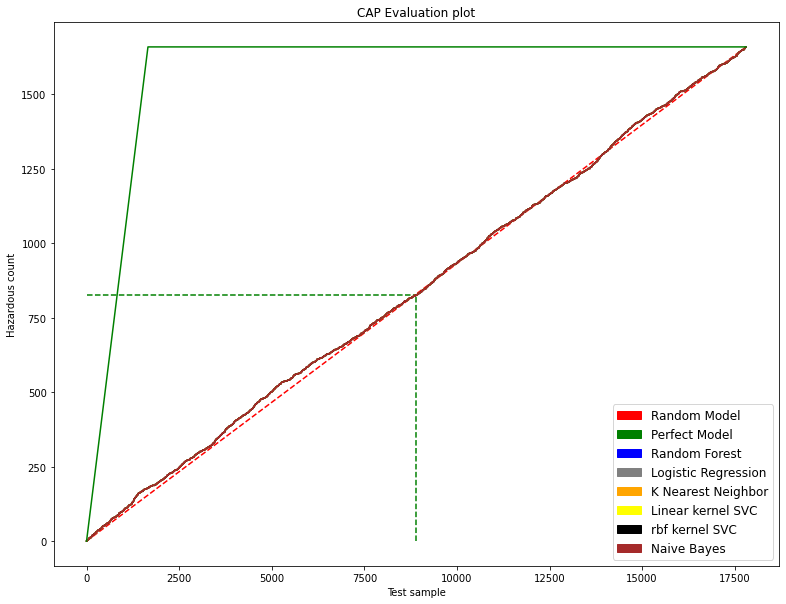

In [26]:
plt.figure(figsize = (13, 10))
plt.ylabel("Hazardous count")
plt.xlabel("Test sample")
plt.title("CAP Evaluation plot")
red_patch= ptch.Patch(color="red", label="Random Model")
green_patch= ptch.Patch(color="green", label="Perfect Model")
x_axis = [x for x in range(total_classes + 1)]

rf_y = make_y_axis_values(y_prob_random_forest, y_test)
blue_patch= ptch.Patch(color="blue", label="Random Forest")

logistic_reg_y = make_y_axis_values(y_prob_logistic_reg, y_test)
gray_patch= ptch.Patch(color="gray", label="Logistic Regression")

knn_y = make_y_axis_values(y_prob_knn, y_test)
orange_patch= ptch.Patch(color="orange", label="K Nearest Neighbor")

svc_y = make_y_axis_values(y_prob_linear_svc, y_test)
yellow_patch= ptch.Patch(color="yellow", label="Linear kernel SVC")

kernel_svc_y = make_y_axis_values(y_prob_kernel_svc, y_test)
black_patch= ptch.Patch(color="black", label="rbf kernel SVC")

nb_y = make_y_axis_values(y_prob_naive_bayes, y_test)
brown_patch= ptch.Patch(color="brown", label="Naive Bayes")

# Point where vertical line will cut trained model
index = int((50*total_classes / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, rf_y[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [rf_y[index], rf_y[index]], c = 'g', linestyle = '--')

plt.legend(handles=[red_patch, green_patch, blue_patch, gray_patch, orange_patch, yellow_patch, black_patch, brown_patch], loc=4, prop={'size': 12})
plt.plot([0, total_classes], [0, first_class_count], c='r', linestyle='--')
plt.plot(x_axis, rf_y, c='blue')
plt.plot(x_axis, logistic_reg_y, c='gray')
plt.plot(x_axis, knn_y, c='orange')
plt.plot(x_axis, svc_y, c='yellow')
plt.plot(x_axis, kernel_svc_y, c='black')
plt.plot(x_axis, nb_y, c='brown')
plt.plot([0, first_class_count, total_classes], [0, first_class_count, first_class_count], c='green')

In [27]:
rf_y[index] * 100 / max(rf_y)

49.819059107358264